# Plastic Classification using Transfer Learning
# 
# This notebook trains a deep learning model to classify different types of plastic using TensorFlow with GPU acceleration.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import datetime

In [2]:
# Verify GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 2. Dataset Preparation and Augmentation

# Dataset parameters
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
INPUT_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 8  # HDPE, LDPE, Other, PET, PP, PS, PVC, Non Plastic

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Path configurations (modify according to your dataset structure)
data_dir = './Dataset'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')
test_dir = os.path.join(data_dir, 'test')

In [4]:
# Data augmentation for training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test data generators (only rescaling)
test_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Class names and indices
class_names = list(train_generator.class_indices.keys())
class_indices = train_generator.class_indices
print("\nClass names:", class_names)

Found 2350 images belonging to 8 classes.
Found 1434 images belonging to 8 classes.
Found 1267 images belonging to 8 classes.

Class names: ['HDPE', 'LDPA', 'NON PLASTIC', 'Other', 'PET', 'PP', 'PS', 'PVC']


In [5]:
# 3. Model Building with Transfer Learning

def build_model():
    # Load pre-trained MobileNetV2 (excluding top layers)
    base_model = applications.MobileNetV2(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze base model layers
    base_model.trainable = False
    
    # Create new model on top
    inputs = tf.keras.Input(shape=INPUT_SHAPE)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)  # Regularization
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    
    return model

model = build_model()

In [6]:
# 4. Model Compilation


# Learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 8)                 1032  

In [7]:
# 5. Training Configuration

# Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = callbacks.ModelCheckpoint(
    'best_model.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir)

# Training parameters
EPOCHS = 50

# 6. Model Training

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, tensorboard_callback]
)


c:\Users\Likhith Reddy\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
22/74 [=======>......................] - ETA: 9s - loss: 2.3547 - accuracy: 0.2216

c:\Users\Likhith Reddy\.pyenv\pyenv-win\versions\3.9.0\lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


74/74 [==============================] - 25s 257ms/step - loss: 1.9036 - accuracy: 0.3817 - val_loss: 1.0629 - val_accuracy: 0.7448
Epoch 2/50
74/74 [==============================] - 18s 239ms/step - loss: 1.4040 - accuracy: 0.5379 - val_loss: 0.9003 - val_accuracy: 0.7880
Epoch 3/50
74/74 [==============================] - 17s 235ms/step - loss: 1.2129 - accuracy: 0.6072 - val_loss: 0.8091 - val_accuracy: 0.8096
Epoch 4/50
74/74 [==============================] - 19s 255ms/step - loss: 1.0654 - accuracy: 0.6579 - val_loss: 0.7358 - val_accuracy: 0.8110
Epoch 5/50
74/74 [==============================] - 20s 269ms/step - loss: 0.9874 - accuracy: 0.6877 - val_loss: 0.6906 - val_accuracy: 0.8264
Epoch 6/50
74/74 [==============================] - 17s 234ms/step - loss: 0.9077 - accuracy: 0.7102 - val_loss: 0.6225 - val_accuracy: 0.8354
Epoch 7/50
74/74 [==============================] - 17s 234ms/step - loss: 0.8549 - accuracy: 0.7230 - val_loss: 0.6187 - val_accuracy: 0.8333
Epoch 8/50

In [8]:
# 7. Model Evaluation

# Load best model
model = models.load_model('best_model.h5')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc:.2%}")
print(f"Test loss: {test_loss:.4f}")


40/40 [==============================] - 4s 74ms/step - loss: 0.2723 - accuracy: 0.9203

Test accuracy: 92.03%
Test loss: 0.2723


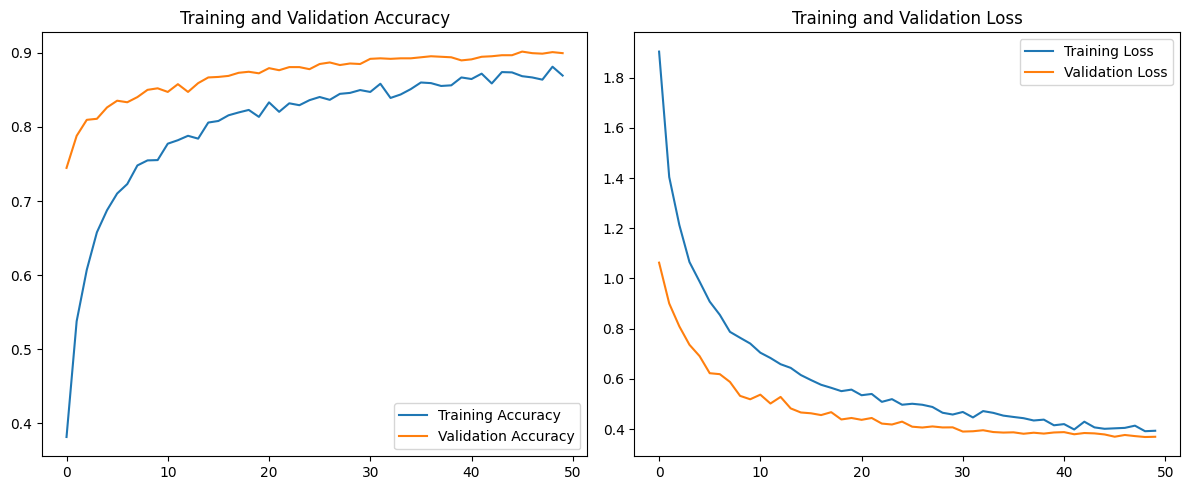

In [9]:
# 8. Training Visualization

# Plot training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.tight_layout()
    plt.show()

plot_history(history)


In [10]:
# 9. Save Final Model

# %%
model.save('plastic_classifier.h5')
print("Model saved successfully!")


Model saved successfully!


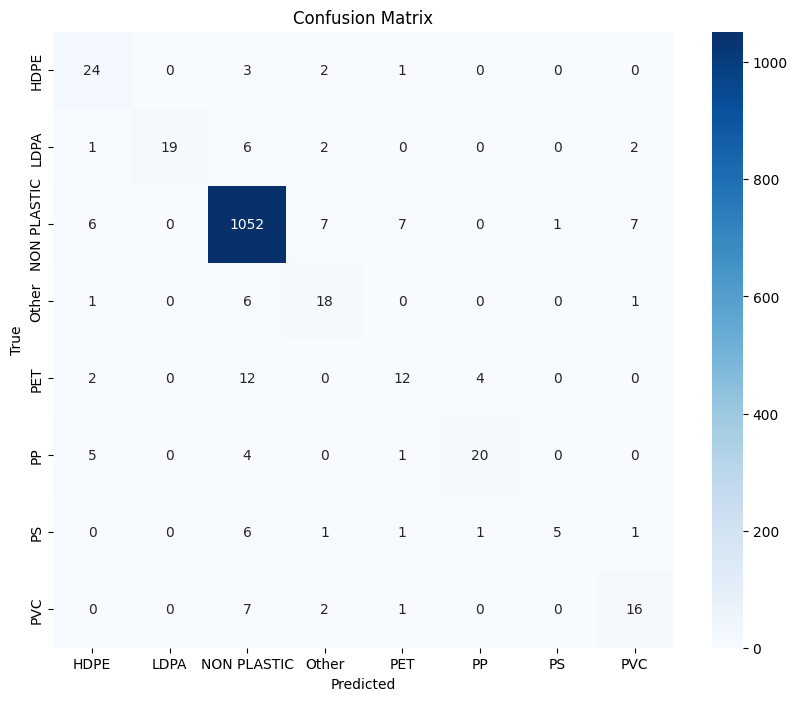

In [11]:
def plot_confusion_matrix():
     test_generator.reset()
     predictions = model.predict(test_generator)
     predicted_classes = np.argmax(predictions, axis=1)
    
     cm = confusion_matrix(test_generator.classes, predicted_classes)
     plt.figure(figsize=(10, 8))
     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names,
                 yticklabels=class_names)
     plt.xlabel('Predicted')
     plt.ylabel('True')
     plt.title('Confusion Matrix')
     plt.show()

plot_confusion_matrix()

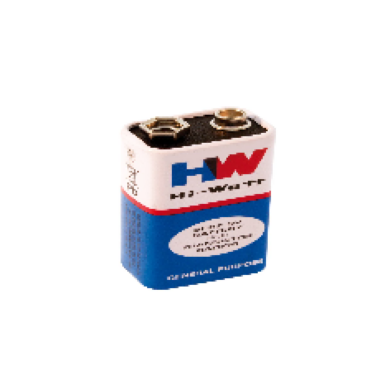

Predicted class: NON PLASTIC
Confidence: 98.13%


('NON PLASTIC', 0.9813368)

In [13]:
# 10. Prediction Function

# %%
def predict_plastic_type(image_path, model):
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=IMG_SIZE
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    img_array /= 255.0  # Normalize

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")
    return predicted_class, confidence


predict_plastic_type('test3.jpg', model)
